# 1. Subject model

In [22]:
import numpy as np
import pandas as pd
import pickle

from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Embedding, SimpleRNN
from keras.callbacks import EarlyStopping

import tensorflow as tf

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import roc_auc_score

import sys 
sys.path.append("../")
import text

import warnings
warnings.filterwarnings("ignore")

In [23]:
EmailInfo=pd.read_csv("../email_05.csv")
Subject_content=EmailInfo[["subject","spam"]]
Subject_content.fillna(value="",inplace=True)

In [24]:
porter_stemmer = PorterStemmer()
stop_words=list(text.stop_words())
def stem_tokenizer(text):
    words=[porter_stemmer.stem(token) for token in word_tokenize(text.lower())]
    return " ".join([w for w in words if w not in stop_words])

messages=EmailInfo["subject"]
for i in range(len(messages)):
    messages[i]=stem_tokenizer(str(messages[i]))
    if i%10000==0:
        print("{} done.".format(i))
    
messages

0 done.
10000 done.
20000 done.
30000 done.
40000 done.
50000 done.
60000 done.
70000 done.
80000 done.


0                fw june 29 -- bna inc. daili labor report
1                                          ngx failov plan
2                                            intranet site
3                           fw ena upstream compani inform
4                                        new master physic
                               ...                        
85198    gb2312 b c2hvzxmgznjvbsb3d3cubg92zwluzmfzaglvb...
85199    gb2312 b c2hvzxmgznjvbsb3d3cubg92zwluzmfzaglvb...
85200    gb2312 b c2hvzxmgznjvbsb3d3cubg92zwluzmfzaglvb...
85201    gb2312 b c2hvzxmgznjvbsb3d3cubg92zwluzmfzaglvb...
85202    gb2312 b c2hvzxmgznjvbsb3d3cubg92zwluzmfzaglvb...
Name: subject, Length: 85203, dtype: object

In [25]:
stop_words=list(text.stop_words())
max_vocab=30000
max_len=30

tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(messages)
sequences = tokenizer.texts_to_sequences(messages)
word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=max_len)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f814b58e450>]],
      dtype=object)

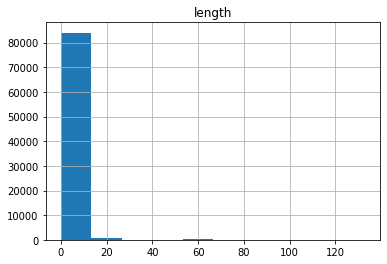

In [26]:
lens=[]
for seq in sequences:
    lens.append(len(seq))
lens=pd.DataFrame({"length":lens})
lens.hist()

In [27]:
# with open("./subject_feature/vector05.p","wb") as f:
#     pickle.dump(data,f)
# with open("./subject_feature/label05.p","wb") as f:
#     pickle.dump(pd.get_dummies(EmailInfo["spam"]).values,f)

# 06subject

In [13]:
EmailInfo=pd.read_csv("../email_06.csv")
Subject_content=EmailInfo[["subject","spam"]]
Subject_content.fillna(value="",inplace=True)

In [14]:
porter_stemmer = PorterStemmer()
stop_words=list(text.stop_words())
def stem_tokenizer(text):
    words=[porter_stemmer.stem(token) for token in word_tokenize(text.lower())]
    return " ".join([w for w in words if w not in stop_words])

messages=EmailInfo["subject"]
for i in range(len(messages)):
    messages[i]=stem_tokenizer(str(messages[i]))
    if i%10000==0:
        print("{} done.".format(i))
    
messages

0 done.
10000 done.
20000 done.
30000 done.


0        new cathol mail list run
1                              12
2              take moment explor
3                           greet
4               loan 3.17 27 term
                   ...           
35283          watcher daili news
35284        number 1 market pick
35285              product health
35286                            
35287              diet plan roof
Name: subject, Length: 35288, dtype: object

In [16]:
sequences = tokenizer.texts_to_sequences(messages)
word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=max_len)

35283

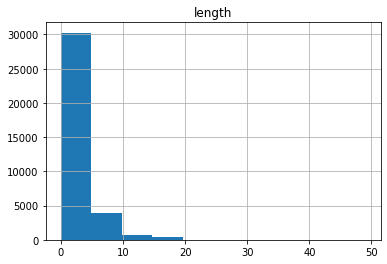

In [18]:
lens=[]
for seq in sequences:
    if len(seq)<50:
        lens.append(len(seq))
lens=pd.DataFrame({"length":lens})
lens.hist()
len(lens)

In [19]:
# with open("./subject_feature/vector06.p","wb") as f:
#     pickle.dump(data,f)
# with open("./subject_feature/label06.p","wb") as f:
#     pickle.dump(pd.get_dummies(EmailInfo["spam"]).values,f)

In [39]:
x_train,x_test,y_train,y_test=train_test_split(data[:10000],pd.get_dummies(EmailInfo["spam"]).values[:10000],shuffle=True,random_state=42,test_size=0.15)

# Simple RNN

In [40]:
# This bit of configuration magic is required by some GPUs and not others.
# this assumes there is only one gpu, change accordingly if you have more
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if  len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    assert tf.config.experimental.get_memory_growth(physical_devices[0]) == True

In [7]:
import random
random.seed(42)

batchsize=100

def auroc(y_true, y_pred):
    return tf.compat.v1.py_func(roc_auc_score, (y_true, y_pred), tf.double)

def RNN_train(x_train, y_train, x_val, y_val, embedding_mat_columns, test=False):
    
    model = Sequential()
    model.add(Embedding(input_dim=max_vocab,output_dim=embedding_mat_columns,input_length=max_len))
    model.add(SimpleRNN(units=embedding_mat_columns,return_sequences=True))
    model.add(SimpleRNN(units=embedding_mat_columns))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc', auroc])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode="min", verbose=2, restore_best_weights=True)
    if not test:
        model.fit(x_train, y_train, epochs=100, batch_size=batchsize, validation_data=( x_val, y_val ),callbacks=[early_stopping])
    else:
        model.fit(x_train, y_train, epochs=100, batch_size=batchsize, validation_split=0.1, callbacks=[early_stopping])
        
    y_pred=model.predict(x_val)
    f=np.vectorize(lambda x:0 if x<0.5 else 1)
    acc=np.mean(f(y_pred)==y_val)
    auc=roc_auc_score(y_val,y_pred)
    if not test:
        print("Val accuracy is {0:.3f}. Val auc is {1:.3f}.".format(acc,auc))
    return [0,acc,auc]

def LSTM_train(x_train, y_train, x_val, y_val, embedding_mat_columns, test=False):
    
    model = Sequential()
    model.add(Embedding(input_dim=max_vocab,output_dim=embedding_mat_columns,input_length=max_len))
    model.add(LSTM(units=embedding_mat_columns,return_sequences=True))
    model.add(LSTM(units=embedding_mat_columns))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc', auroc])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode="min", verbose=2, restore_best_weights=True)
    if not test:
        model.fit(x_train, y_train, epochs=100, batch_size=batchsize, validation_data=( x_val, y_val ),callbacks=[early_stopping])
    else:
        model.fit(x_train, y_train, epochs=100, batch_size=batchsize, validation_split=0.1, callbacks=[early_stopping])
        
    y_pred=model.predict(x_val)
    f=np.vectorize(lambda x:0 if x<0.5 else 1)
    acc=np.mean(f(y_pred)==y_val)
    auc=roc_auc_score(y_val,y_pred)
    if not test:
        print("Val accuracy is {0:.3f}. Val auc is {1:.3f}.".format(acc,auc))
    return [0,acc,auc]

def cross_val(model,x_train,y_train,x_test,y_test,cv,embedding_mat_columns):
    acclst=[]
    auclst=[]
#     mask=np.arange(len(x_train))
#     random.shuffle(mask)
#     x_train,y_train=x_train[mask],y_train[mask]
    if cv!=0:
        for i in range(cv):
            n=len(x_train)
            n_val=n//cv
            x_val,y_val=x_train[i*n_val:(i+1)*n_val],y_train[i*n_val:(i+1)*n_val]
            mask=np.array([True]*len(x_train))
            mask[i*n_val:(i+1)*n_val]=False
            x_tr,y_tr=x_train[mask],y_train[mask]

            print("-------------------------------------------------------")
            acc=model(x_tr,y_tr,x_val,y_val,embedding_mat_columns)
            acclst.append(acc[1])
            auclst.append(acc[2])
        
    acc=model(x_train,y_train,x_test,y_test,embedding_mat_columns,True)
    print("-------------------------------------------------------")
    if cv!=0:
        print("5-fold accuracy is {0:.3f}. 5-fold auc is {1:.3f}.".format(np.mean(acclst),np.mean(auclst)))
    print("test accuracy is {0:.3f}. test auc is {1:.3f}.".format(acc[1],acc[2]))

In [43]:
cross_val(RNN_train,x_train,y_train,x_test,y_test,cv=5,embedding_mat_columns=64)

-------------------------------------------------------
Train on 6800 samples, validate on 1700 samples
Epoch 1/100
6800/6800 [==============================] - 3s 447us/step - loss: 0.4562 - acc: 0.7876 - auroc: 0.7916 - val_loss: 0.2908 - val_acc: 0.8553 - val_auroc: 0.9456
Epoch 2/100
6800/6800 [==============================] - 3s 421us/step - loss: 0.1141 - acc: 0.9566 - auroc: 0.9942 - val_loss: 0.1861 - val_acc: 0.9141 - val_auroc: 0.9709
Epoch 3/100
6800/6800 [==============================] - 3s 434us/step - loss: 0.0437 - acc: 0.9844 - auroc: 0.9988 - val_loss: 0.1694 - val_acc: 0.9271 - val_auroc: 0.9776
Epoch 4/100
6800/6800 [==============================] - 3s 459us/step - loss: 0.0276 - acc: 0.9899 - auroc: 0.9994 - val_loss: 0.1713 - val_acc: 0.9271 - val_auroc: 0.9791
Epoch 5/100
6800/6800 [==============================] - 3s 451us/step - loss: 0.0223 - acc: 0.9907 - auroc: 0.9996 - val_loss: 0.1792 - val_acc: 0.9253 - val_auroc: 0.9789
Epoch 6/100
6800/6800 [========

In [ ]:
# LSTM summary
model = Sequential()
model.add(Embedding(input_dim=max_vocab,output_dim=embedding_mat_columns,input_length=max_len))
model.add(LSTM(units=embedding_mat_columns,return_sequences=True))
model.add(LSTM(units=embedding_mat_columns))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc', auroc])
model.summary()

# RNN summary
model = Sequential()
model.add(Embedding(input_dim=max_vocab,output_dim=embedding_mat_columns,input_length=max_len))
model.add(LSTM(units=embedding_mat_columns,return_sequences=True))
model.add(LSTM(units=embedding_mat_columns))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc', auroc])
model.summary()

# LSTM

In [44]:
cross_val(LSTM_train,x_train,y_train,x_test,y_test,cv=5,embedding_mat_columns=64)

-------------------------------------------------------
Train on 6800 samples, validate on 1700 samples
Epoch 1/100
6800/6800 [==============================] - 6s 940us/step - loss: 0.4855 - acc: 0.7884 - auroc: 0.7573 - val_loss: 0.2664 - val_acc: 0.8994 - val_auroc: 0.9701
Epoch 2/100
6800/6800 [==============================] - 6s 863us/step - loss: 0.1434 - acc: 0.9504 - auroc: 0.9892 - val_loss: 0.1390 - val_acc: 0.9353 - val_auroc: 0.9829
Epoch 3/100
6800/6800 [==============================] - 6s 864us/step - loss: 0.0592 - acc: 0.9760 - auroc: 0.9970 - val_loss: 0.1356 - val_acc: 0.9412 - val_auroc: 0.9848
Epoch 4/100
6800/6800 [==============================] - 6s 864us/step - loss: 0.0369 - acc: 0.9862 - auroc: 0.9987 - val_loss: 0.1502 - val_acc: 0.9394 - val_auroc: 0.9846
Epoch 5/100
6800/6800 [==============================] - 6s 868us/step - loss: 0.0288 - acc: 0.9891 - auroc: 0.9991 - val_loss: 0.1883 - val_acc: 0.9371 - val_auroc: 0.9829
Epoch 6/100
6800/6800 [========

# LSTM subject test all

In [30]:
# This bit of configuration magic is required by some GPUs and not others.
# this assumes there is only one gpu, change accordingly if you have more
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if  len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    assert tf.config.experimental.get_memory_growth(physical_devices[0]) == True
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [56]:
max_vocab=30000
max_len=30

with open("./subject_feature/vector05.p","rb") as f:
    x_train=pickle.load(f)
with open("./subject_feature/label05.p","rb") as f:
    y_train=pickle.load(f)
    
with open("./subject_feature/vector06.p","rb") as f:
    x_test=pickle.load(f)
with open("./subject_feature/label06.p","rb") as f:
    y_test=pickle.load(f)
    
x_train=x_train
y_train=y_train
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((85203, 30), (85203, 2), (35288, 30), (35288, 2))

In [59]:
import pickle
import datetime
import time
from keras.optimizers import Adam

%matplotlib inline

import sys
sys.path.append("../")
from notebook_utils import get_logger,LoggingCallback

# helper routing to log a message with time
def log_message( label_string ):
    ts = time.time()
    st = datetime.datetime.fromtimestamp( ts ).strftime( '%Y-%m-%d %H:%M:%S:%f' )
    print("{}: {}".format(st, label_string))
    with open("training_log.txt","a") as f:
        f.write("{}: {}\n".format(st, label_string))

def auroc(y_true, y_pred):
    return tf.compat.v1.py_func(roc_auc_score, (y_true, y_pred), tf.double)

def LSTM_train(x_train, y_train, x_val, y_val, embedding_mat_columns,name):
    
    model = Sequential()
    model.add(Embedding(input_dim=max_vocab,output_dim=embedding_mat_columns,input_length=max_len))
    model.add(LSTM(units=embedding_mat_columns,return_sequences=True))
    model.add(LSTM(units=embedding_mat_columns))
    model.add(Dense(2, activation='softmax'))
    opt=Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['acc', ])#auroc

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode="min", verbose=2, restore_best_weights=True)
    result=model.fit(x_train, y_train, epochs=100, batch_size=batchsize, validation_split=0.1, #validation_data=(x_val, y_val), 
                     callbacks=[early_stopping,LoggingCallback(3,logger)])
    
    model.save("./models/LSTM_model_{}.format(name)")
    
    with open("./models/LSTM_result_{}.p".format(name),"wb") as f:
        pickle.dump(result.history,f)

def train_all(model,x_train,y_train,x_test,y_test,embedding_mat_columns,name):
    log_message( "start" )
    model(x_train,y_train,x_test,y_test,embedding_mat_columns,name)
    log_message( "end" )

In [60]:
batchsize=108
name="subject_body_1"
logger=get_logger("LSTM_{}.log".format(name))
train_all(LSTM_train,x_train,y_train,x_test,y_test,embedding_mat_columns=64,name=name)

2020-04-26 17:23:16:699507: start
Train on 76682 samples, validate on 8521 samples
Epoch 1/100
76682/76682 [==============================] - 40s 523us/step - loss: 0.2159 - acc: 0.9018 - val_loss: 0.2135 - val_acc: 0.9033
2020-04-26 17:23:57|	0: TRAIN loss 0.21594813  ||  VAL loss 0.21354558
Epoch 2/100
76682/76682 [==============================] - 39s 513us/step - loss: 0.1109 - acc: 0.9525 - val_loss: 0.2186 - val_acc: 0.9002
Epoch 3/100
76682/76682 [==============================] - 38s 496us/step - loss: 0.0867 - acc: 0.9612 - val_loss: 0.2217 - val_acc: 0.9079
Epoch 4/100
76682/76682 [==============================] - 38s 492us/step - loss: 0.0758 - acc: 0.9637 - val_loss: 0.2188 - val_acc: 0.9171
2020-04-26 17:25:53|	3: TRAIN loss 0.07579289  ||  VAL loss 0.21879032
Epoch 5/100
76682/76682 [==============================] - 38s 490us/step - loss: 0.0688 - acc: 0.9674 - val_loss: 0.2164 - val_acc: 0.9149
Epoch 6/100
76682/76682 [==============================] - 38s 489us/step -